In [15]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_33636/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

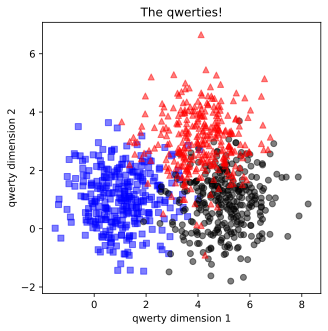

In [16]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 3]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [17]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 16
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset,  batch_size=test_batch_size)

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {train_batch_size} samples')

There are 50 batches, each with 16 samples


# The model

In [18]:
def create_the_qwety_net(optimizer_algo):
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer_func = getattr(torch.optim, optimizer_algo)
    optimizer      = optimizer_func(net.parameters(), lr=0.01)

    return net, loss_func, optimizer

In [19]:
# Test the model with optimizer type as input

# Try 'SGD', 'RMSprop', and 'Adam'
optim = create_the_qwety_net('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)

# A function that trains the model

In [20]:
num_epochs = 50

def train_the_model(optimizer_type):
  
  net, loss_func, optimizer = create_the_qwety_net(optimizer_type)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      y_hat = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses, net

# A function that plots the results

In [21]:
# A function that plots the results
def plot_the_results(optimizer_type):
  # Compute accuracy over entire dataset (train+test)
  y_hat       = net(data)
  predictions = torch.argmax(y_hat, axis=1)
  accuracy    = (predictions == labels).float()
  total_acc   = torch.mean(100 * accuracy).item()

  # And accuracy by group
  accuracy_by_group = np.zeros(3)
  for i in range(3):
    accuracy_by_group[i] = 100 * torch.mean(accuracy[labels == i])

  # Create the figure
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

  # Plot the loss function
  ax[0, 0].plot(losses.detach())
  ax[0, 0].set_ylabel('Loss')
  ax[0, 0].set_xlabel('Epoch')
  ax[0, 0].set_title(f'{optimizer_type}: Losses')

  # Plot the accuracy functions
  ax[0, 1].plot(train_acc, label='Train')
  ax[0, 1].plot(test_acc, label='Test')
  ax[0, 1].set_ylabel('Accuracy (%)')
  ax[0, 1].set_xlabel('Epoch')
  ax[0, 1].set_title(f'{optimizer_type}: Accuracy')
  ax[0, 1].legend()

  # Plot overall accuracy by group
  ax[1, 0].bar(range(3), accuracy_by_group)
  ax[1, 0].set_ylim([np.min(accuracy_by_group) - 5, np.max(accuracy_by_group) + 5])
  ax[1, 0].set_xticks([0, 1, 2])
  ax[1, 0].set_xlabel('Group')
  ax[1, 0].set_ylabel('Accuracy (%)')
  ax[1, 0].set_title(f'{optimizer_type}: Accuracy by Group')

  # Scatterplot of correct and incorrect labeled data
  # Data markers
  color_shapes = ['bs', 'ko', 'g^']
  for i in range(3):
    # Plot all data points
    ax[1, 1].plot(data[labels == i, 0], data[labels == i, 1], color_shapes[i], alpha=0.3, label=f'Group {i}')

    # Cross-out the incorrect ones
    idx_err = (accuracy == 0) & (labels == i)
    ax[1, 1].plot(data[idx_err, 0], data[idx_err, 1], 'rx')

  ax[1, 1].set_title(f'{optimizer_type}: Total accuracy: {total_acc:.2f}%')
  ax[1, 1].set_xlabel('qwerty dimension 1')
  ax[1, 1].set_ylabel('qwerty dimension 2')
  ax[1, 1].legend()

  plt.tight_layout()
  plt.show()


# Now for the optimizer comparison

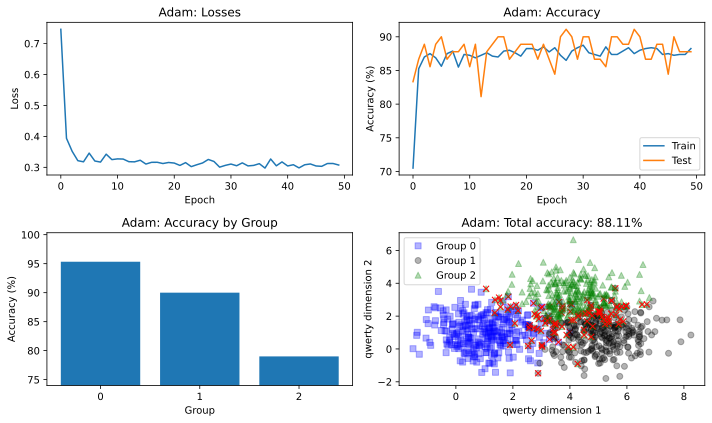

In [22]:
# Run the model for one optimizer
optimizer_type = 'Adam'
train_acc, test_acc, losses, net = train_the_model(optimizer_type=optimizer_type)

# Visualize!
plot_the_results(optimizer_type=optimizer_type)

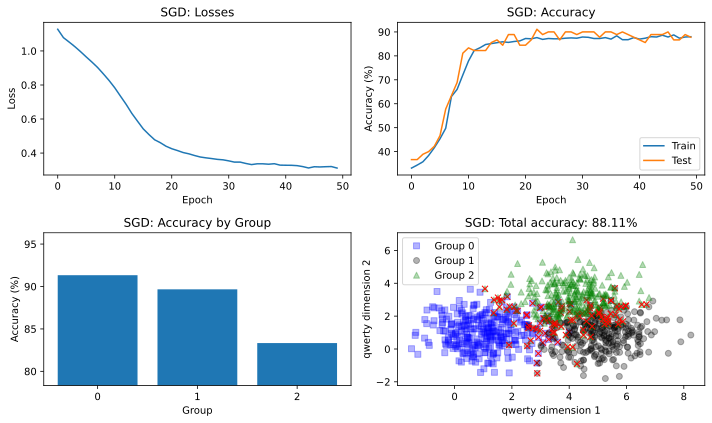

--------------------------------------------------------------------


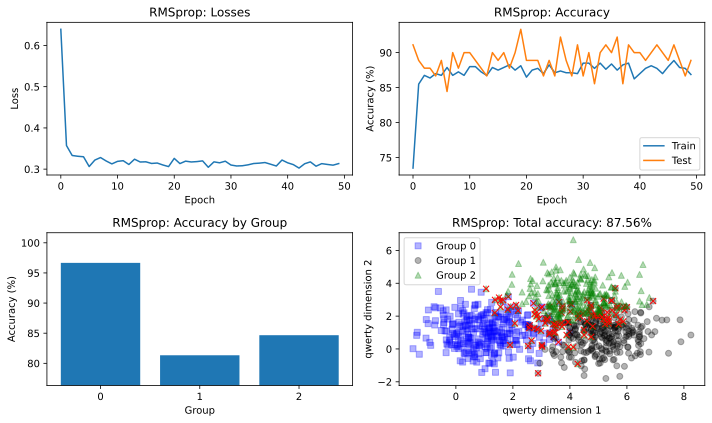

--------------------------------------------------------------------


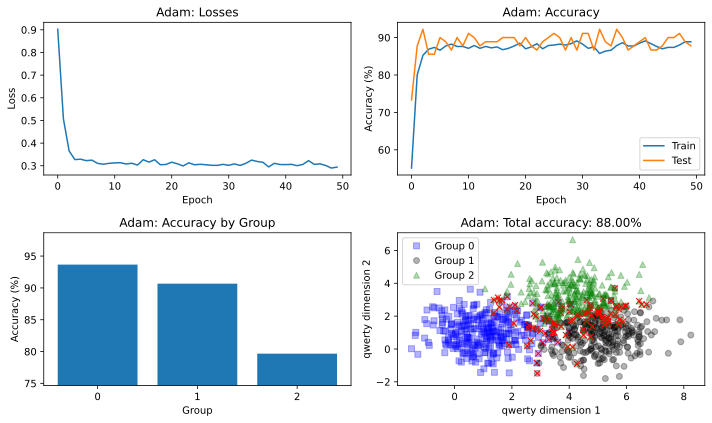

--------------------------------------------------------------------
['SGD: Train 87.9% | Test: 87.9%', 'RMSprop: Train 87.7% | Test: 89.4%', 'Adam: Train 88.1% | Test: 88.8%']


In [23]:
# Now run through all of them
# Average performance
performance = []

for optimizer_i in ['SGD','RMSprop','Adam']:
  train_acc, test_acc, losses, net = train_the_model(optimizer_type=optimizer_i)
  plot_the_results(optimizer_type=optimizer_i)
  print('--------------------------------------------------------------------')
  # Store the final results
  train = np.mean(train_acc[-10:])
  test  = np.mean(test_acc[-10:])

  performance.append(f'{optimizer_i}: Train {train:.1f}% | Test: {test:.1f}%')

print(performance)

# Additional explorations
1) Accuracy seems to be different between the different qwerties categories. Is this consistent across the optimizers?
   Or does it seem like some optimizers are better at some categories? How do you interpret your answer, and what does
   it indicate about metaparameters of DL and their effects on performance?

2) The results here indicate that all three optimizers perform roughly equally well, but SGD needs more training. Is 
   that still the case with a smaller or larger learning rate?

3) The method of showing the final performance (printing out a list) is... not very pretty. What kind of visualization
   do you think would better illustrate the performances across the optimizers? Code it! 